In [12]:
import db_util
import gc
import gzip
import json
import math
import matplotlib.pyplot as plt
import nltk
import numpy
import pandas as pd
import pymongo
import pysentiment
import re
import seaborn as sns
import sentiment_util
import scipy
import spacy
import time
import unicodedata
import warnings

from textblob import TextBlob
from textstat.textstat import textstat 
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

warnings.simplefilter('ignore')

In [3]:
client = db_util.connect_mongo(host='localhost', username=None, password=None, port=27017, db='product')

# 0. Exploratory data analysis

## 0.1 Rating distribution

In [ ]:
category_list = ['Books', 'Electronics', 'Movies & TV', 'CDs & Vinyl', 'Clothing, Shoes & Jewelry', 
                 'Home & Kitchen', 'Kindle Store', 'Sports & Outdoors', 'Cell Phones & Accessories', 
                 'Health & Personal Care', 'Toys & Games', 'Video Games', 'Tools & Home Improvement', 
                 'Beauty', 'Apps for Android', 'Office Products', 'Pet Supplies', 'Automotive', 
                 'Grocery & Gourmet Food', 'Patio, Lawn & Garden', 'Baby', 'Digital Music', 'Musical Instruments', 
                 'Amazon Instant Video']

In [147]:
cursor = client.item_review.aggregate([{'$match': {'overall': {'$exists': True},
                                                   'itemPrice': {'$exists': True} } },
                                       {'$project': {'overall': 1,
                                                     'itemPrice': 1,
                                                     'category_all': {'$arrayElemAt': ['$itemCategories', 0] } } },
                                       {'$project': {'overall': 1,
                                                     'itemPrice': 1,
                                                     'category': {'$arrayElemAt': ['$category_all', 0] } } } ],
                                      allowDiskUse=True)
pd_rating = pd.DataFrame(list(cursor))
pd_rating = pd_rating[pd_rating['category'].isin(category_list)]
pd_rating_freq = pd_rating.groupby('overall').size().reset_index(name='count')
pd_rating_freq_cat = pd_rating.groupby(['category', 'overall']).size().reset_index(name='count')
print 'Average rating of all reviews: ', pd_rating['overall'].mean()

4.208225676344785

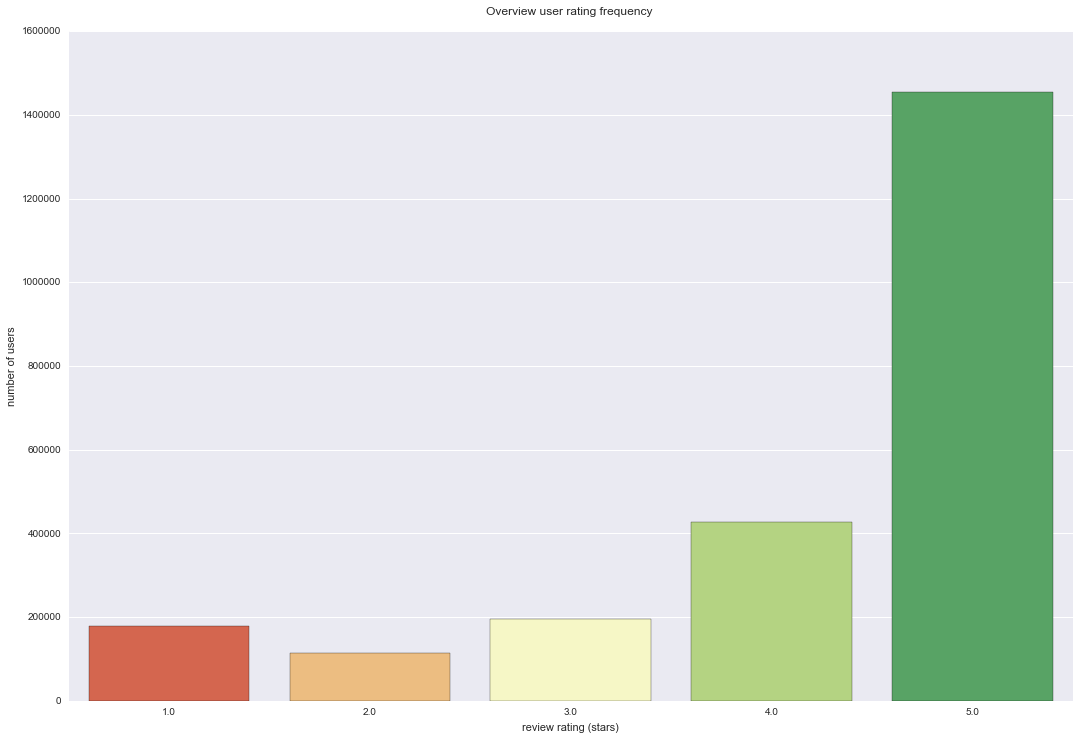

In [148]:
sns.plt.figure(figsize=(12, 8))
g = sns.barplot(x="overall", y="count", data=pd_rating_freq, palette=sns.color_palette("RdYlGn", 5))
g.set(xlabel='review rating (stars)', ylabel='number of users', title = 'Overview user rating frequency \n')
sns.plt.show()

In [154]:
del pd_rating, pd_rating_freq, pd_rating_freq_cat
gc.collect()

## 0.2 Price distribution

In [6]:
select_fields = ['asin', 'itemPrice']
cursor = client.item_review.find({'itemPrice': {'$exists': True} }, 
                                 {'asin': 1, 'itemPrice': 1})
pd_price = pd.DataFrame(list(cursor), columns=select_fields).drop_duplicates()
print 'Average price of all items', pd_price['itemPrice'].mean()

34.04928270375066

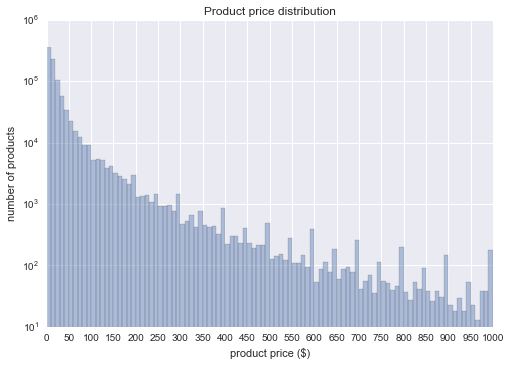

In [7]:
sns.plt.figure(figsize=(18, 12))
g = sns.distplot(pd_price.itemPrice.dropna(), bins=100, kde=False, rug=False)
g.set_xticks(list(range(0, int(math.ceil(pd_price.itemPrice.max()))+1, 50)))
g.set_xlabel('product price ($)')
g.set_yscale('log')
g.set_ylabel('number of products')
g.set_title('Product price distribution \n')
sns.plt.show()

In [8]:
del pd_price

# 1. Is there a relation between price and reviews?

## 1.1 Price ~ rating and price ~ number of reviews

In [81]:
select_fields = ['asin', 'avg_rating','count_review', 'item_price']
cursor = client.item_review.aggregate([ {'$match': {'itemPrice': {'$exists': True} } },
                                        {'$group': {'_id': '$asin',
                                                    'item_price': {'$avg': '$itemPrice'},
                                                    'avg_rating': {'$avg': "$overall"},
                                                    'count_review': {'$sum': 1} } } ],
                                      allowDiskUse=True)
pd_rating = pd.DataFrame(list(cursor))
pd_rating.columns = select_fields

In [52]:
print 'Correlation between avg. rating and item price: ', scipy.stats.pearsonr(pd_rating.avg_rating, pd_rating.item_price)
print 'Correlation between # reviews and item price: ', scipy.stats.pearsonr(pd_rating.count_review, pd_rating.item_price)
print 'Average number of reviews received per product: ', pd_rating.count_review.mean()
print '\n'
print 'Number of reviews received (quantile): \n', pd_rating.count_review.quantile([0.25, 0.5, 0.75, 0.95, 0.965, 0.99, 1])

Average number of reviews received per product:  2.69633777941
Number of reviews received (quantile): 
0.250       1.0
0.500       1.0
0.750       2.0
0.950       8.0
0.965      10.0
0.990      25.0
1.000    3225.0
Name: count_review, dtype: float64


In [94]:
del pd_rating
gc.collect()

158

## 1.3 Price ~ review length

In [4]:
select_fields = ['asin', 'item_price', 'item_sales_rank', 'review_text']
cursor = client.item_review.find({'itemPrice': {'$exists': True},
                                  'reviewText': {'$exists': True},
                                  'itemSalesRank': {'$exists': True} }, 
                                 {'_id': 0, 'asin': 1, 'itemPrice': 1, 'reviewText': 1, 'itemSalesRank': 1})
pd_review = pd.DataFrame(list(cursor))
pd_review.columns = select_fields
pd_review['review_length'] = pd_review['review_text'].apply(lambda text: len(text.split()))
pd_review['sales_rank'] = pd_review['item_sales_rank'].apply(lambda v: v.values()[0] if v != {} else None)
pd_review = pd_review[pd_review['sales_rank'].notnull()]
del pd_review['item_sales_rank']

In [55]:
pd_review_length_agg = pd_review.groupby(['asin', 'item_price', 'sales_rank']) \
                                .agg({'review_text': 'count', 'review_length': 'mean'}).reset_index()
pd_review_length_agg = pd_review_length_agg[pd_review_length_agg.review_text >= 8]

In [79]:
print 'Number of words in a review (quantile): \n', pd_review.review_length.quantile([0.25, 0.5, 0.75, 1])
print 'Correlation between review length and item price: ', \
    scipy.stats.pearsonr(pd_review_length_agg.item_price, pd_review_length_agg['review_length'])
print 'Correlation between review count and item price: ', \
    scipy.stats.pearsonr(pd_review_length_agg.item_price, pd_review_length_agg['review_text'])
print 'Correlation between review length and rank: ', \
    scipy.stats.pearsonr(pd_review_length_agg.sales_rank, pd_review_length_agg['review_length'])
print 'Correlation between review count and rank: ', \
    scipy.stats.pearsonr(pd_review_length_agg.sales_rank, pd_review_length_agg['review_text'])

Number of words in a review (quantile): 
0.25      24.0
0.50      35.0
0.75      65.0
1.00    5178.0
Name: review_length, dtype: float64
Correlation between review length and item price:  (0.13938779655633232, 1.9780676003930639e-128)
Correlation between review count and item price:  (-0.010769258168506567, 0.063782638493438265)
Correlation between review length and rank:  (0.13648337211390735, 3.6316389636708987e-123)
Correlation between review count and rank:  (-0.0099606175747678806, 0.086437137495896876)


In [80]:
del pd_review, pd_review_length_agg

# 2. Review ~ helpfulness

## 2.1 Review voted ratio

In [3]:
cursor = client.item_review.aggregate([{'$match': {'helpful': {'$exists': True},
                                                   'reviewText': {'$exists': True} } },
                                       {'$project': {'_id': 0,
                                                     'asin': 1,
                                                     'overall': 1,
                                                     'reviewerID': 1,
                                                     'vote_helpful': {'$arrayElemAt': ['$helpful', 0] },
                                                     'vote_total': {'$arrayElemAt': ['$helpful', 1] },
                                                     'category_all': {'$arrayElemAt': ['$itemCategories', 0] } } },
                                       {'$project': {'_id': 0,
                                                     'asin': 1,
                                                     'overall': 1,
                                                     'reviewerID': 1,
                                                     'vote_helpful': 1,
                                                     'vote_total': 1,
                                                     'category': {'$arrayElemAt': ['$category_all', 0] } } } ],
                                      allowDiskUse=True)
pd_helpful = pd.DataFrame(list(cursor))

category_list = ['Books', 'Electronics', 'Movies & TV', 'CDs & Vinyl', 'Clothing, Shoes & Jewelry', 
                 'Home & Kitchen', 'Kindle Store', 'Sports & Outdoors', 'Cell Phones & Accessories', 
                 'Health & Personal Care', 'Toys & Games', 'Video Games', 'Tools & Home Improvement', 
                 'Beauty', 'Apps for Android', 'Office Products', 'Pet Supplies', 'Automotive', 
                 'Grocery & Gourmet Food', 'Patio, Lawn & Garden', 'Baby', 'Digital Music', 'Musical Instruments', 
                 'Amazon Instant Video']
pd_helpful = pd_helpful[pd_helpful['category'].isin(category_list)]

In [15]:
pd_review_helpful = pd_helpful.groupby('category').agg({'asin': 'count', 
                                                        'vote_total': lambda cell: (cell > 0).sum()}).reset_index()
pd_review_helpful = pd_review_helpful[pd_review_helpful['category'].isin(category_list)]
pd_review_helpful['voted_review_ratio'] = pd_review_helpful['vote_total'].div(pd_review_helpful['asin'])
pd_review_helpful = pd_review_helpful.sort_values(['voted_review_ratio'], ascending=[False]).reset_index()

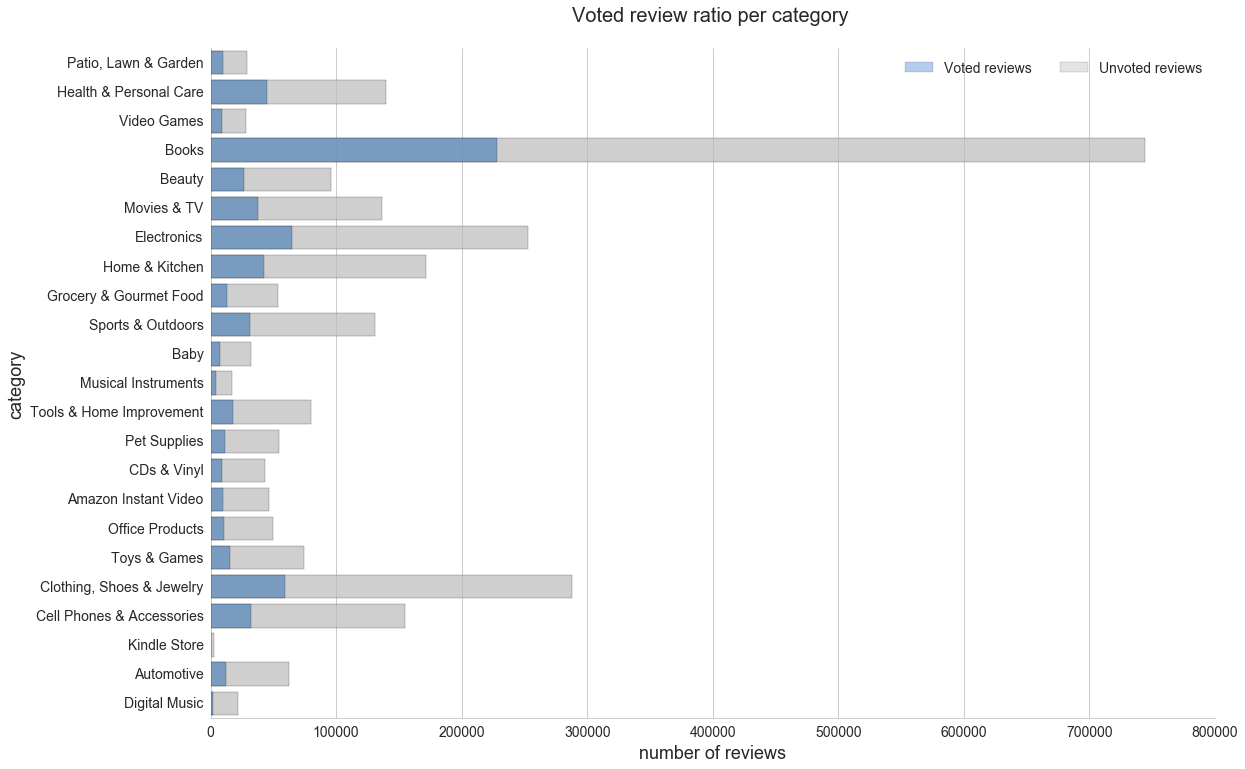

In [154]:
#Set general plot properties
sns.set(style="whitegrid")
sns.plt.figure(figsize=(18, 12))
# plot total
g_t = sns.barplot(x = pd_review_helpful.asin, y = pd_review_helpful.category, color = '#bbbbbb', alpha=0.7)
# plot voted
g_b = sns.barplot(x = pd_review_helpful.vote_total, y = pd_review_helpful.category, color = '#4484cc', alpha=0.7)

bar_t = sns.plt.Rectangle((0,0), 1, 1, fc='#bbbbbb', edgecolor = 'none', alpha=0.4)
bar_b = sns.plt.Rectangle((0,0), 1, 1, fc='#4484cc', edgecolor = 'none', alpha=0.4)
l = sns.plt.legend([bar_b, bar_t], ['Voted reviews', 'Unvoted reviews'], loc=1, ncol = 2, prop={'size':14})
l.draw_frame(False)

sns.despine(left=True)
g_b.set_title('Voted review ratio per category \n', fontsize=20)
g_b.set_xlabel('number of reviews')
g_b.set_ylabel('category')
    
for item in [g_b.xaxis.label, g_b.yaxis.label]:
    item.set_fontsize(18)
for item in g_b.get_xticklabels() + g_b.get_yticklabels():
    item.set_fontsize(14)

sns.plt.show()

## 2.2 Review helpful ratio

In [104]:
pd_helpful_filtered = pd_helpful[pd_helpful.vote_total >= 10]
pd_helpful_filtered['helpful_ratio'] = pd_helpful_filtered.vote_helpful / pd_helpful_filtered.vote_total
pd_helpful_filtered_agg = pd_helpful_filtered.groupby('category').agg({'helpful_ratio': 'mean'}).reset_index()
pd_helpful_filtered_agg = pd_helpful_filtered_agg.sort_values(['helpful_ratio'], ascending=[False])

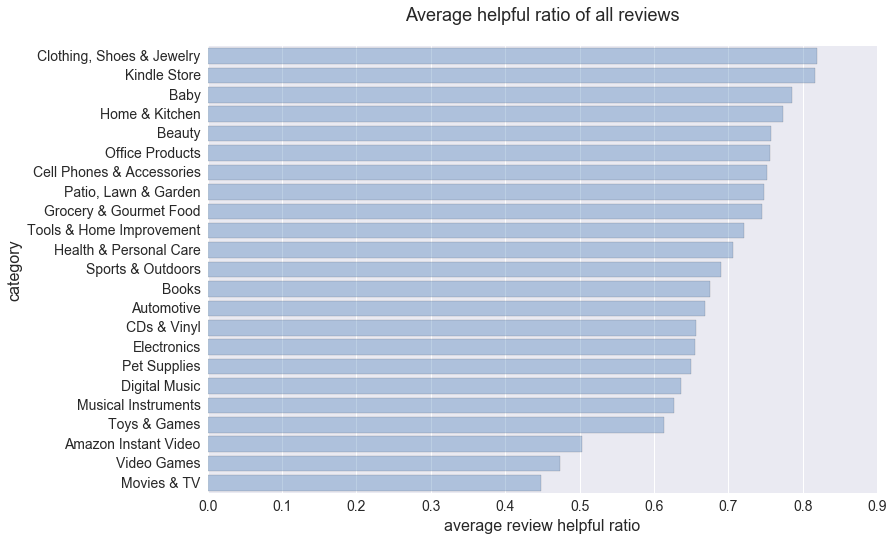

In [149]:
sns.set(style="darkgrid")
sns.plt.figure(figsize=(18, 12))
g = sns.barplot(x = pd_helpful_filtered_agg.helpful_ratio, y = pd_helpful_filtered_agg.category, color = '#4484cc', alpha=0.4)
g.set_title('Average helpful ratio of all reviews\n', fontsize=20)
g.set_xticklabels(numpy.linspace(0, 1.0, 11), fontsize=14)
g.set_xlabel('average review helpful ratio', fontsize=18)
g.set_ylabel('category', fontsize=18)
for item in g.get_yticklabels():
    item.set_fontsize(14)
sns.plt.show()

# 3. Sentiment analysis - electronics

In [95]:
cursor = client.item_review.aggregate([{'$match': {'helpful': {'$exists': True},
                                                   'overall': {'$exists': True},
                                                   'itemPrice': {'$exists': True},
                                                   'reviewText': {'$exists': True} } },
                                       {'$project': {'_id': 0,
                                                     'asin': 1,
                                                     'overall': 1,
                                                     'reviewerID': 1,
                                                     'unixReviewTime': 1,
                                                     'reviewText': 1,
                                                     'itemBrand': 1,
                                                     'summary': 1,
                                                     'vote_helpful': {'$arrayElemAt': ['$helpful', 0] },
                                                     'vote_total': {'$arrayElemAt': ['$helpful', 1] },
                                                     'category_all': {'$arrayElemAt': ['$itemCategories', 0] } } },
                                       {'$project': {'asin': 1,
                                                     'overall': 1,
                                                     'reviewerID': 1,
                                                     'unixReviewTime': 1,
                                                     'reviewText': 1,
                                                     'itemBrand': 1,
                                                     'summary': 1,
                                                     'vote_helpful': 1,
                                                     'vote_total': 1,
                                                     'category': {'$arrayElemAt': ['$category_all', 0] } } },
                                        {'$match': {'category': {'$eq': 'Electronics'} } }],
                                      allowDiskUse=True)
pd_elec_review = pd.DataFrame(list(cursor))

In [96]:
pd_elec_review = pd_elec_review[pd_elec_review['reviewText'] != '']

In [99]:
pd_elec_review = pd_elec_review[pd_elec_review['vote_total'] >= 8]

In [97]:
pd_elec_review['readability'] = pd_elec_review['reviewText'].apply(textstat.automated_readability_index)
;

''

In [98]:
pd_elec_review['sentiment'] = pd_elec_review['reviewText'].apply(lambda row: TextBlob(row).sentiment.polarity)
pd_elec_review['subjectivity'] = pd_elec_review['reviewText'].apply(lambda row: TextBlob(row).sentiment.subjectivity)

In [100]:
parsed_docs = []
nlp = spacy.load('en')

for doc in nlp.pipe(pd_elec_review.reviewText, batch_size=500, n_threads=6):
    parsed_docs.append(doc)

pd_elec_review['parsed_text'] = parsed_docs

In [101]:
pd_elec_review['text_lemma'] = pd_elec_review['parsed_text'].apply(lambda row: sentiment_util.return_lemma_text(row))

In [102]:
text_rating = []

for i in range(1,6 ):
    text_rating.append(pd_elec_review[pd_elec_review['overall'] == i])

In [107]:
stop = [x.encode('ascii') for x in stopwords.words('english')]
stop_self_defined = ['buy', 'come', 'day', 'get', 'go', 'good', 'great', 'know', 'lot', 'month', 'need', 'nice', 'say', 'set',
                     'tablet', 'take', 'tell', 'thing', 'think', 'use', 'want', 'way', 'week', 'year', 'len', 'run', 'review',
                     'like', 'look', 'new', 'device', 'time', 'make', 'bit', 'little', 'try', 'ne', 'product', 'company',
                     'sure', 'find', 'order', 'item', 'open', 'hour', 'right', 'feel', 'second']
stop = stop + stop_self_defined

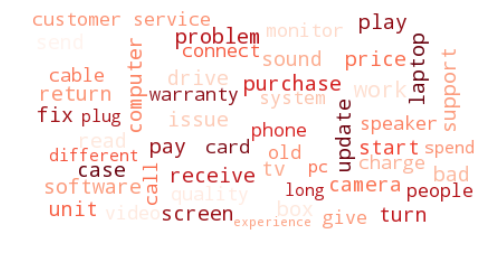

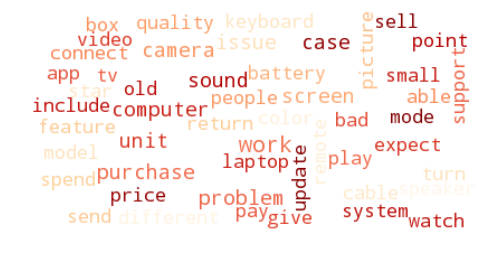

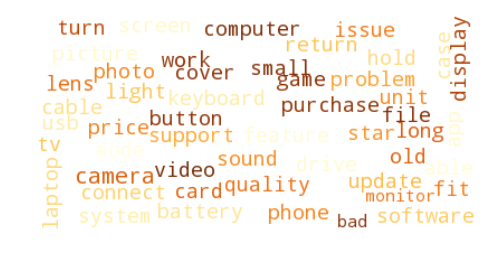

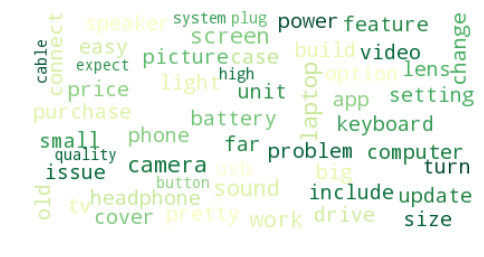

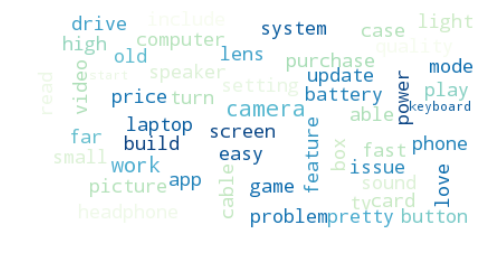

In [109]:
colormap_list = ['Reds', 'OrRd', 'YlOrBr', 'YlGn', 'GnBu']
for i in range(len(text_rating)):
    text = ' '.join(text_rating[i].text_lemma)
    text = unicodedata.normalize('NFKD', text).encode('ascii','ignore')
    wordcloud = WordCloud(background_color='white', 
                          relative_scaling = 0.2,
                          stopwords=stop,
                          colormap=colormap_list[i], max_words=50,
                          max_font_size=20).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('../plots/reviews_word_cloud_{}.png'.format(i+1), bbox_inches='tight')
    plt.show()